In [1]:
library(igraph)

In [2]:
df <- read.table('http://opsahl.co.uk/tnet/datasets/Davis_southern_club_women-two_mode.txt')
df.renamed <- cbind(sprintf("w%d", df[,1]), sprintf("e%d", df[,2]))

In [3]:
g <- graph.data.frame(df.renamed, directed=FALSE)

In [4]:
classes <- grepl("w", V(g)$name)
V(g)$color <- ifelse(classes, "orange", "lightblue")

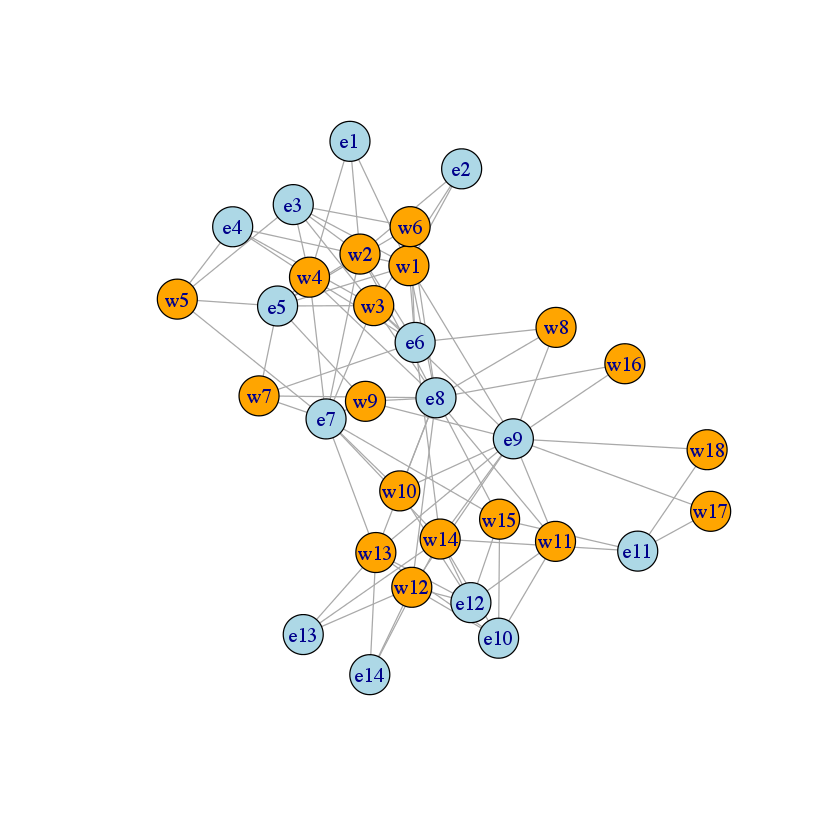

In [5]:
plot.igraph(g, layout=layout.fruchterman.reingold)

Straight off the bat, the force-directed layout above uncovers some structure that we will be looking at in more detail later.

## One-mode projections

So far we looked at two-mode networks. One thing we can do with two-mode networks is to project them to a single mode.

In [6]:
library(tnet)

Loading required package: survival
tnet: Analysis of Weighted, Two-mode, and Longitudinal networks.
Type ?tnet for help.


In [7]:
w2e.net <- as.tnet(df, type="binary two-mode tnet")
women.projected <- projecting_tm(w2e.net, method="sum")

In [8]:
women.graph <- graph.edgelist(as.matrix(women.projected[,c(1,2)]))
E(women.graph)$weight <- as.numeric(women.projected[,3]) / 2
women.undirected <- as.undirected(women.graph)

In [9]:
get.adjacency(women.undirected, attr="weight")

18 x 18 sparse Matrix of class "dgCMatrix"
                                         
 [1,] . 6 7 6 3 4 3 3 3 2 2 2 2 2 1 2 1 1
 [2,] 6 . 6 6 3 4 4 2 3 2 1 1 2 2 2 1 . .
 [3,] 7 6 . 6 4 4 4 3 4 3 2 2 3 3 2 2 1 1
 [4,] 6 6 6 . 4 4 4 2 3 2 1 1 2 2 2 1 . .
 [5,] 3 3 4 4 . 2 2 . 2 1 . . 1 1 1 . . .
 [6,] 4 4 4 4 2 . 3 2 2 1 1 1 1 1 1 1 . .
 [7,] 3 4 4 4 2 3 . 2 3 2 1 1 2 2 2 1 . .
 [8,] 3 2 3 2 . 2 2 . 2 2 2 2 2 2 1 2 1 1
 [9,] 3 3 4 3 2 2 3 2 . 3 2 2 3 2 2 2 1 1
[10,] 2 2 3 2 1 1 2 2 3 . 3 3 4 3 3 2 1 1
[11,] 2 1 2 1 . 1 1 2 2 3 . 4 4 3 3 2 1 1
[12,] 2 1 2 1 . 1 1 2 2 3 4 . 6 5 3 2 1 1
[13,] 2 2 3 2 1 1 2 2 3 4 4 6 . 6 4 2 1 1
[14,] 2 2 3 2 1 1 2 2 2 3 3 5 6 . 4 1 2 2
[15,] 1 2 2 2 1 1 2 1 2 3 3 3 4 4 . 1 1 1
[16,] 2 1 2 1 . 1 1 2 2 2 2 2 2 1 1 . 1 1
[17,] 1 . 1 . . . . 1 1 1 1 1 1 2 1 1 . 2
[18,] 1 . 1 . . . . 1 1 1 1 1 1 2 1 1 2 .

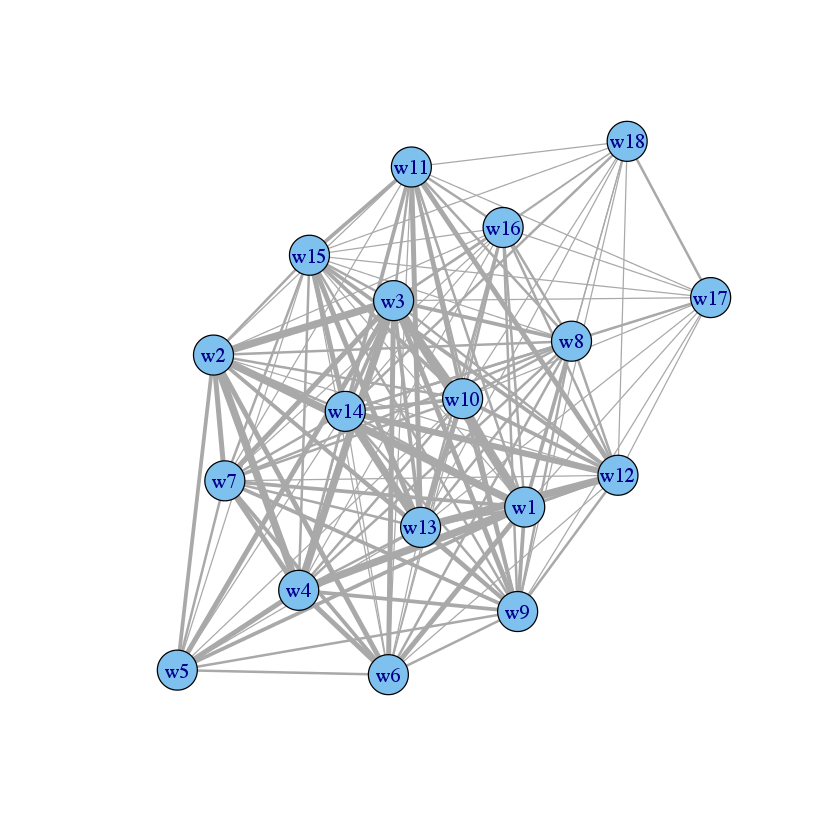

In [10]:
plot.igraph(women.undirected, layout=layout.fruchterman.reingold,
            vertex.label=sprintf("w%d", V(women.undirected)),
            edge.width=E(women.undirected)$weight)

Note that almost everyone is linked to everyone, and it is difficult to discern any structure. Yet if we run a community detection algorithm, it does find structure:

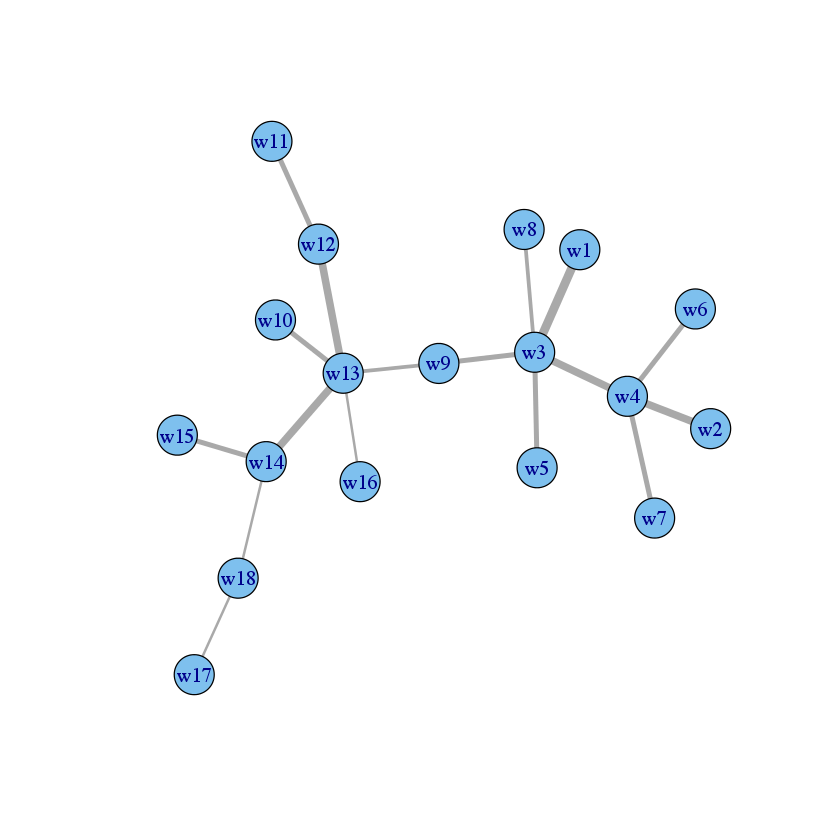

In [47]:
women.undirected.inv <- as.undirected(women.undirected)
E(women.undirected.inv)$weight <- -E(women.undirected)$weight
mst <- minimum.spanning.tree(women.undirected.inv, algorithm="prim")
plot.igraph(mst,
            vertex.label=sprintf("w%d", V(mst)),
            edge.width=-E(mst)$weight)

[1] 0.1518653

1,1,1,1,1,1,1,2,1,2,2,2,2,2,2,2,2,2
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18


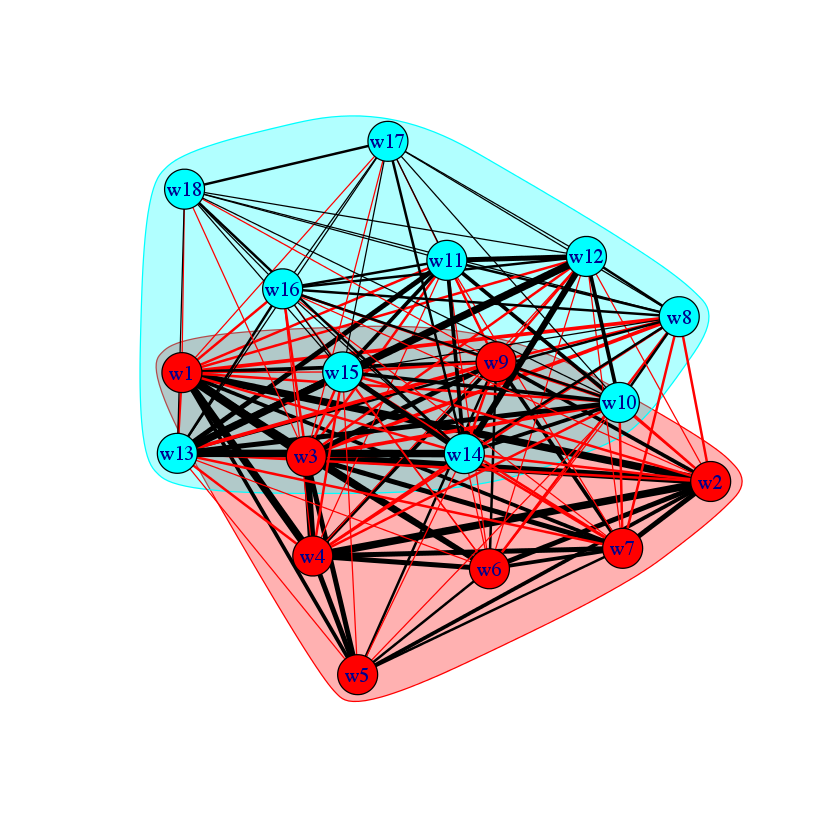

In [11]:
wc <- leading.eigenvector.community(women.undirected)
modularity(wc)
t(cbind(membership(wc), V(women.undirected)))
plot(wc, women.undirected,
     layout=layout.fruchterman.reingold,
     vertex.label=sprintf("w%d", V(women.undirected)),
     edge.width=E(women.undirected)$weight
    )

In [12]:
library(disparityfilter)

In [13]:
women.backbone <- get.backbone(graph=women.undirected, alpha=0.26, directed=FALSE)

Disparity Filter
alpha = 0.26 

Original graph
IGRAPH U-W- 18 139 -- 
+ attr: weight (e/n)

Backbone graph
IGRAPH UNW- 17 35 -- 
+ attr: name (v/c), weight (e/n)


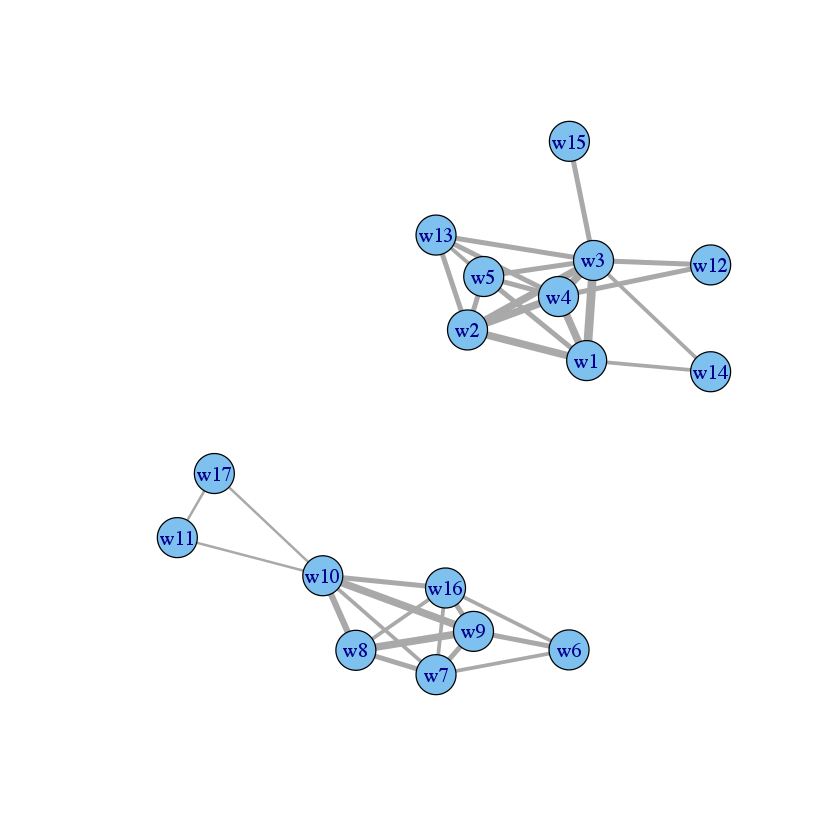

In [14]:
plot.igraph(women.backbone, layout=layout.fruchterman.reingold,
            vertex.label=sprintf("w%s", V(women.backbone)),
            edge.width=E(women.backbone)$weight)

The projection backbone looks interesting, confirming our suspicion that there are two communities present, yet it is also wrong! Note that woman 3 ends up in the same group as woman 13, while they they clearly have different sets of close friends as can be seen from the force-directed layout visualization (first figure).

In [15]:
e2w.net <- as.tnet(cbind(df[,2], df[,1]), type="binary two-mode tnet")
events.projected <- projecting_tm(e2w.net, method="sum")

In [53]:
events.graph <- graph.edgelist(as.matrix(events.projected[,c(1,2)]))
E(events.graph)$weight <- as.numeric(events.projected[,3]) / 2
events.undirected <- as.undirected(events.graph)
V(events.undirected)$color <- array("orange", dim=c(length(V(events.undirected)),1))

In [54]:
get.adjacency(events.undirected, attr="weight")

14 x 14 sparse Matrix of class "dgCMatrix"
                                 
 [1,] . 2 3 2 3 3 2 3 1 . . . . .
 [2,] 2 . 3 2 3 3 2 3 2 . . . . .
 [3,] 3 3 . 4 6 5 4 5 2 . . . . .
 [4,] 2 2 4 . 4 3 3 3 2 . . . . .
 [5,] 3 3 6 4 . 6 6 7 3 . . . . .
 [6,] 3 3 5 3 6 . 5 7 4 1 1 1 1 1
 [7,] 2 2 4 3 6 5 . 8 5 3 2 4 2 2
 [8,] 3 3 5 3 7 7 8 . 9 4 1 5 2 2
 [9,] 1 2 2 2 3 4 5 9 . 4 3 5 3 3
[10,] . . . . . 1 3 4 4 . 2 5 3 3
[11,] . . . . . 1 2 1 3 2 . 2 1 1
[12,] . . . . . 1 4 5 5 5 2 . 3 3
[13,] . . . . . 1 2 2 3 3 1 3 . 3
[14,] . . . . . 1 2 2 3 3 1 3 3 .

The events graph is a little easier to parse visually, both as as an adjacency matrix and as a graphical representation. There clearly seems to be three clusters of events, two clusters of five nodes each far apart, and one of four nodes that joins the others.

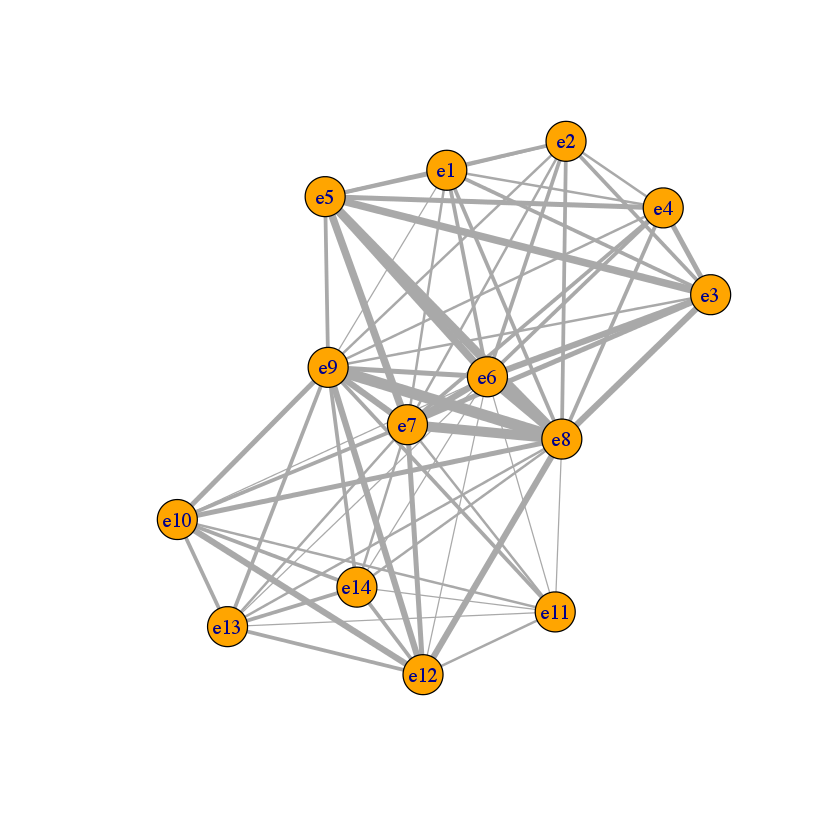

In [55]:
plot.igraph(events.undirected, layout=layout.fruchterman.reingold,
            vertex.label=sprintf("e%d", V(events.undirected)),
            edge.width=E(events.undirected)$weight)

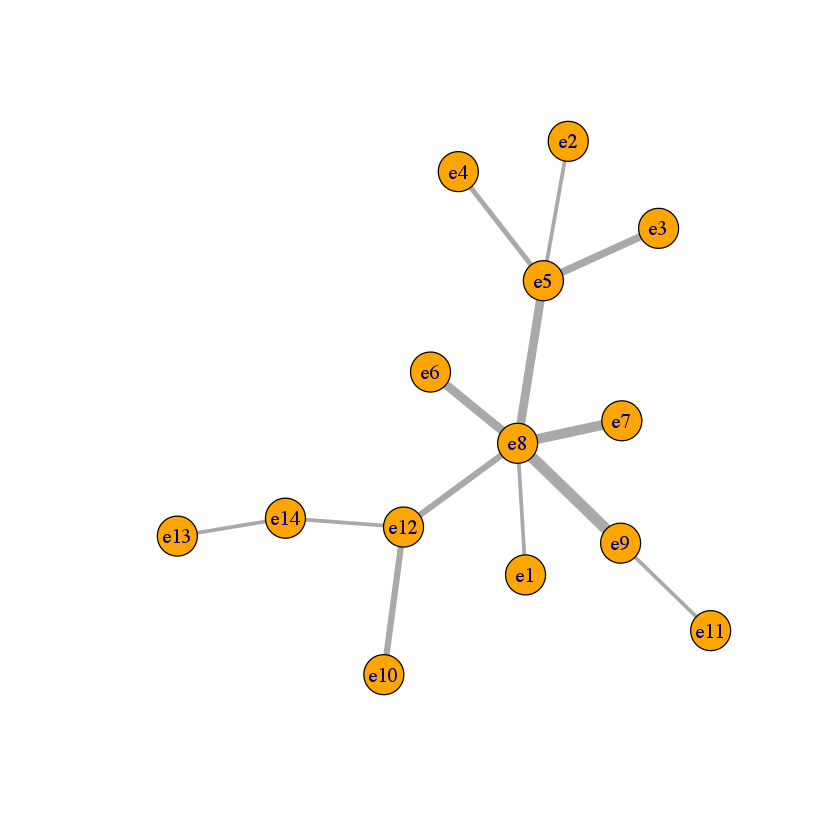

In [56]:
events.undirected.inv <- as.undirected(events.undirected)
E(events.undirected.inv)$weight <- -E(events.undirected)$weight
mst <- minimum.spanning.tree(events.undirected.inv, algorithm="prim")
plot.igraph(mst,
            vertex.label=sprintf("e%d", V(mst)),
            edge.width=-E(mst)$weight)

[1] 0.1720674

1,1,1,1,1,1,1,1,2,2,2,2,2,2
1,2,3,4,5,6,7,8,9,10,11,12,13,14


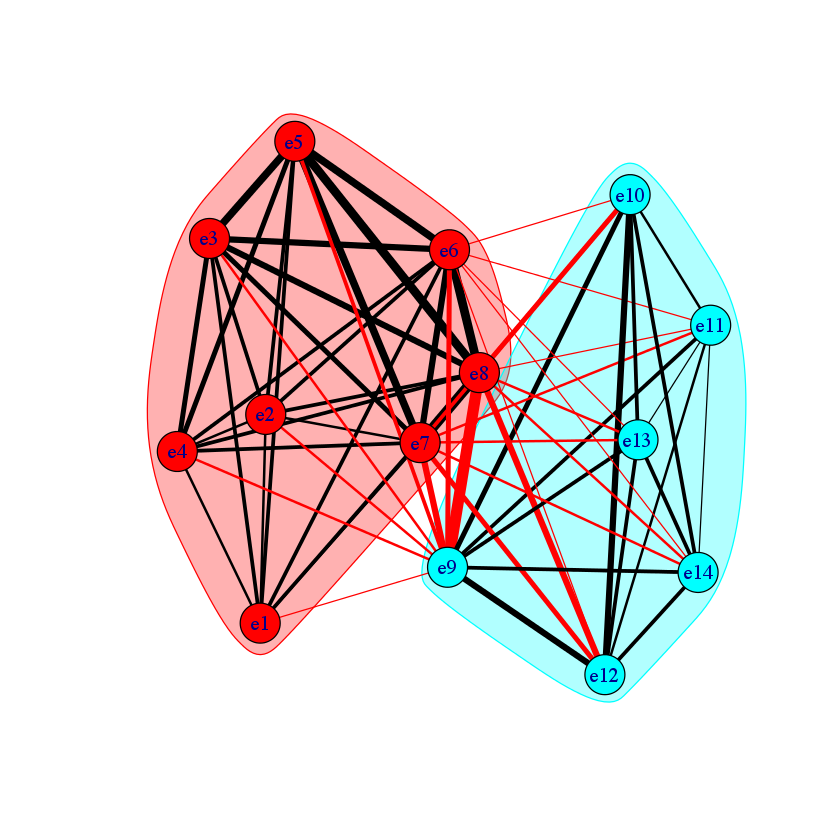

In [57]:
wc <- leading.eigenvector.community(events.undirected)
modularity(wc)
t(cbind(membership(wc), V(events.undirected)))
plot(wc, events.undirected,
     layout=layout.fruchterman.reingold,
     vertex.label=sprintf("e%s", V(events.undirected)),
     edge.width=E(events.undirected)$weight
    )

The better-separated event space also has a better modularity coefficient.